In [1]:
import cv2
import os
import numpy as np
from scipy.spatial.transform import Rotation
from matplotlib import pyplot as plt
import json
import math
import face_alignment

In [2]:
import xml.etree.ElementTree as ET
import numpy as np
import json
from matplotlib import pyplot as plt
from landmarkUtils import extract_landmarks_media_pipe
from scipy import signal

# Input block

In [33]:
# lmPath = "/Volumes/KINGSTON/Facial Feature Motion Clip/rollingInTheDeep/raw_mediapipe_landmark.npy"
lmPath = "E:/Facial Feature Motion Clip/rollingInTheDeep/raw_mediapipe_landmark.npy"
outputPath = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/motion.json"
# info from video
t_segment = [0, 168]
t_ref = 159
# info of target animation
start = 0
fps = 30
min_cutoff = 0.0001
beta = 1.5

In [34]:
with open("mediaPipeMapping.json", "r") as f:
    maping = json.load(f)

staticLandmarkIndices = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
keypointIndicies = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["brow"]["rightLower"]+maping["brow"]["rightUpper"]+maping["brow"]["leftUpper"]+maping["brow"]["leftLower"]+maping["eye"]["right"]+maping["eye"]["left"]+maping["lips"]["inner"]+maping["lips"]["outer"]
data = np.load(lmPath)


### Rotation algorithm from http://web.stanford.edu/class/cs273/refs/umeyama.pdf

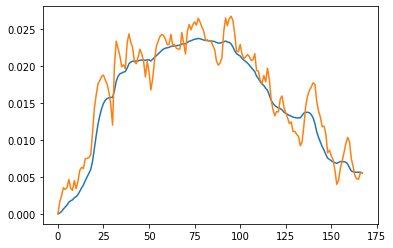

In [35]:
def compute_rotation(X, Y):
    # the algorithm uses X and Y notation, where the input dimension should be (M x N)
    # where M is the number of dimension and N is the number of points. the output is
    # R, c, t, where they satisfies min_{R, c, t} ||(c*R*X+t) - Y||^2
    mu_x = X.mean(axis=1)
    mu_y = Y.mean(axis=1)
    rho2_x = X.var(axis=1).sum()
    rho2_y = Y.var(axis=1).sum()
    cov_xy = 1.0 / X.shape[1] * (Y-np.expand_dims(mu_y, axis=1))@(X-np.expand_dims(mu_x, axis=1)).T
    # SVD on the covariance matrix
    U, D, V_T = np.linalg.svd(cov_xy)
    D = np.diag(D)
    # prepare sign flipping matrix S, which need to be altered at some point
    S = np.identity(3)
    # update matrix S based on the rank of cov_xy
    if np.linalg.matrix_rank(cov_xy) >= X.shape[0]-1:
        if (np.linalg.det(cov_xy) < 0):
            S[-1,-1] = -1 
    else:
        det_U = np.linalg.det(U)
        det_V = np.linalg.det(V_T)
        if (det_U * det_V < 0):
            S[-1,-1] = -1  
    # compute rotation and scale and translation
    R = U@S@V_T
    c = (1.0 / rho2_x) * np.trace(D @ S)
    t = mu_y - c * R @ mu_x
    # X_prime = c * R @ frame_i.T + np.expand_dims(t, 1)
    # X_prime = rotated_frame_i.T
    return R, c, np.expand_dims(t, 1)
def rotateToNeutral(neutralPose, data, staticIndices):
    # neturalPose should be a numpy array of shape (N, M)
    # data should be a numpy array of shape (T, N, M)
    # staticIndices should be a list of integers 
    outData = np.zeros(data.shape)
    for i in range(0, data.shape[0]):
        frame_t = data[i,staticIndices]
        R, c, t = compute_rotation(frame_t.T, neutralPose[staticIndices].T)
        outData[i] = (c * R @ data[i].T + t).T
    return outData
def smoothing_factor(t_e, cutoff):
    r = 2 * math.pi * cutoff * t_e
    return r / (r + 1)
def exponential_smoothing(a, x, x_prev):
    return a * x + (1 - a) * x_prev
class OneEuroFilter:
    def __init__(self, t0, x0, dx0=0.0, min_cutoff=1.0, beta=0.0,
                 d_cutoff=1.0):
        """Initialize the one euro filter."""
        # The parameters.
        self.min_cutoff = float(min_cutoff)
        self.beta = float(beta)
        self.d_cutoff = float(d_cutoff)
        # Previous values.
        self.x_prev = float(x0)
        self.dx_prev = float(dx0)
        self.t_prev = float(t0)

    def __call__(self, t, x):
        """Compute the filtered signal."""
        t_e = t - self.t_prev
        # The filtered derivative of the signal.
        a_d = smoothing_factor(t_e, self.d_cutoff)
        dx = (x - self.x_prev) / t_e
        dx_hat = exponential_smoothing(a_d, dx, self.dx_prev)

        # The filtered signal.
        cutoff = self.min_cutoff + self.beta * abs(dx_hat)
        a = smoothing_factor(t_e, cutoff)
        x_hat = exponential_smoothing(a, x, self.x_prev)

        # Memorize the previous values.
        self.x_prev = x_hat
        self.dx_prev = dx_hat
        self.t_prev = t
        return x_hat
def runEuro(t, data):
    out = np.zeros(data.shape)
    out[0] = data[0]
    one_euro_filter = OneEuroFilter(t[0], data[0],min_cutoff=min_cutoff,beta=beta)
    for i in range(1, len(t)):
        out[i] = one_euro_filter(t[i], data[i])
    return out
def constrainedOneEuroFilter(data, dataRange, keyFrames):
    # data should be a numpy array of shape (n, )
    # dataRange should be a list of two element, a starting frame and an ending frame [start, end)
    # keyFrames should be a list of keyframes that the model needs is constraint to
    
    # construct partitions of the signal
    dataPartitions = []
    start = 0
    end = dataRange[1] - dataRange[0]
    for i in range(0, len(keyFrames)):
        kf = keyFrames[i] - start # conform it to indexing of array
        if i == 0:
            if (kf>=1):
                dataPartitions.append(data[0:kf])
        else:
            prev_kf = keyFrames[i-1] - start
            dataPartitions.append(data[prev_kf:kf])
    dataPartitions.append(data[keyFrames[-1] - start:])
    out_dataPartition = []
    # using 1 euro filter to perform changes
    for i in range(0, len(dataPartitions)):
        if i < len(dataPartitions)-1:
            forward = dataPartitions[i]
            backward = np.flip(dataPartitions[i])
            
            t = np.arange(0, forward.shape[0])
            alpha = np.arange(forward.shape[0], 0, -1)/forward.shape[0]
#             plt.plot(backward)
            forward = runEuro(t, forward) * alpha
            backward = np.flip(runEuro(t, backward) * alpha)
        
            out_dataPartition.append(forward + backward)
        else:
            forward = dataPartitions[i]
            t = np.arange(0, forward.shape[0])
            out_dataPartition.append(runEuro(t, forward))
    return np.concatenate(out_dataPartition)
def outputToFile(path, arr, fps, start):
    # the input should be in the form of a 2D array with shape [n, ]
    arr_length = arr.shape[0]
    dt = 1.0 / fps
    t_arr = np.arange(0, arr_length) * dt + start
    t_arr = t_arr.tolist()
    arr = arr / arr.max()
    v_arr = arr.tolist()
    
    output = {"t": t_arr, "v": v_arr}
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(output, f)
    return
min_cutoff = 0.0001
beta = 5
t_ref = 0
dataSegment = data[t_segment[0]:t_segment[1]]
ref_frame = data[t_ref]
dataSegment = rotateToNeutral(ref_frame, dataSegment, staticLandmarkIndices)
leftBrowIndices = maping["brow"]["leftUpper"]+list(reversed(maping["brow"]["leftLower"]))+maping["brow"]["rightUpper"]+maping["brow"]["rightLower"]
leftBrowDeviation = np.sqrt(np.square(dataSegment[:,leftBrowIndices]-dataSegment[t_ref:t_ref+1,leftBrowIndices])[:,:,0:2].sum(axis=2).mean(1))
out = constrainedOneEuroFilter(leftBrowDeviation, t_segment, [t_ref, -1])
plt.plot(out)
plt.plot(leftBrowDeviation)
# outputToFile(outputPath, out, fps, start)

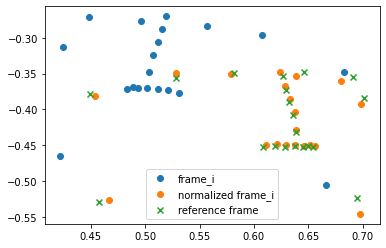

In [8]:
i=35
staticLandmarkIndices = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
normlalized_data = rotateToNeutral(data[0], data, staticLandmarkIndices)
plt.scatter(data[i, staticLandmarkIndices, 0], -data[i, staticLandmarkIndices,1], label="frame_i")
plt.scatter(normlalized_data[i, staticLandmarkIndices, 0], -normlalized_data[i, staticLandmarkIndices,1], label="normalized frame_i")
plt.scatter(data[0, staticLandmarkIndices, 0], -data[0, staticLandmarkIndices,1], marker="x", label="reference frame")
plt.legend()


# 1.2 quantitatively testing the normalization (the more points that are used the more likely there won't be as much warping)

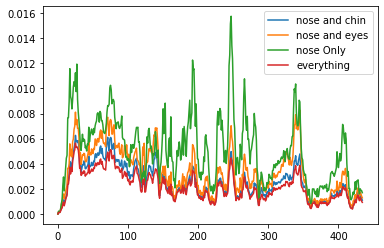

In [9]:
staticLandmarkIndices1 = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
staticLandmarkIndices2 = maping["eye"]["static"]+maping["nose"]["dorsum"]+maping["nose"]["tipLower"]
staticLandmarkIndices3 = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]
staticLandmarkIndicesAll = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["eye"]["static"]+maping["additional_anchors"]
# fitting using the nose and chind data
normlalized_data = rotateToNeutral(data[0], data, staticLandmarkIndices1)
fitting_error = normlalized_data[:, staticLandmarkIndicesAll] - data[0, staticLandmarkIndicesAll]
fitting_error = np.square(fitting_error).sum(axis=2).sum(axis=1)
plt.plot(fitting_error, label="nose and chin")
# fitting using the nose and eye data
normlalized_data = rotateToNeutral(data[0], data, staticLandmarkIndices2)
fitting_error = normlalized_data[:, staticLandmarkIndicesAll] - data[0, staticLandmarkIndicesAll]
fitting_error = np.square(fitting_error).sum(axis=2).sum(axis=1)
plt.plot(fitting_error, label="nose and eyes")
# fitting using nose only
normlalized_data = rotateToNeutral(data[0], data, staticLandmarkIndices3)
fitting_error = normlalized_data[:, staticLandmarkIndicesAll] - data[0, staticLandmarkIndicesAll]
fitting_error = np.square(fitting_error).sum(axis=2).sum(axis=1)
plt.plot(fitting_error, label="nose Only")
# fitting using nose, eye, chin data
normlalized_data = rotateToNeutral(data[0], data, staticLandmarkIndicesAll)
fitting_error = normlalized_data[:, staticLandmarkIndicesAll] - data[0, staticLandmarkIndicesAll]
fitting_error = np.square(fitting_error).sum(axis=2).sum(axis=1)
plt.plot(fitting_error, label="everything")
plt.legend()

This just shows that the more landmarks the better.

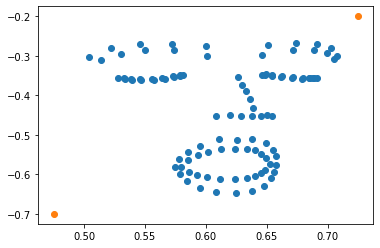

In [14]:
normlalized_data = rotateToNeutral(ref_frame, data, staticLandmarkIndices)    
plt.scatter(normlalized_data[0, keypointIndicies, 0], -normlalized_data[0, keypointIndicies, 1])
plt.scatter([0.475, 0.725], [-0.7, -0.2])

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


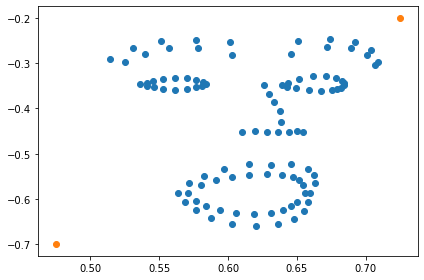

In [11]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
def display_landmark(landmark_arr, fps):
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    def update(i):
        label = 'timestep {0}'.format(i)
        # Update the line and the axes (with a new xlabel). Return a tuple of
        # "artists" that have to be redrawn for this frame.
        landmark_arr_i = landmark_arr[i]
        print(i)
        fig.clf()
        ax = plt.scatter(landmark_arr_i[:, 0], -landmark_arr_i[:, 1])
        ax = plt.scatter([0.475, 0.725], [-0.7, -0.2])
        return ax
    anim = FuncAnimation(fig, update, frames=np.arange(0, landmark_arr.shape[0]), interval=fps)
    f = r"animation.avi" 
    writervideo = animation.FFMpegWriter(fps=25)
    anim.save(f, writer=writervideo)

normlalized_data = rotateToNeutral(ref_frame, data, staticLandmarkIndices)    
# display_landmark(normlalized_data[0:100, keypointIndicies], 30)

# 2. Testing methods to compute contour changes 

### 2.1a General contour information, translation, whole video

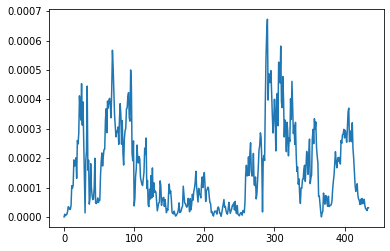

In [15]:
leftBrowIndices = maping["brow"]["leftUpper"]+maping["brow"]["leftLower"]
nose_indices = maping["nose"]["dorsum"]+maping["nose"]["tip"]
leftBrowData = normlalized_data[:,leftBrowIndices]-normlalized_data[0:1,leftBrowIndices]

# leftBrowPositionData = leftBrowData.min(axis=1)
# plt.plot(leftBrowPositionData[:,1], label="min")
# leftBrowPositionData = leftBrowData.max(axis=1)
# plt.plot(leftBrowPositionData[:,1], label="max")
leftBrowPositionData = np.square(leftBrowData-leftBrowData[0:1]).mean(axis=1)
plt.plot(leftBrowPositionData[:,1], label="mean")

In [16]:
leftBrowIndices_loop = maping["brow"]["leftUpper"]+list(reversed(maping["brow"]["leftLower"]))
leftBrowData = normlalized_data[:,leftBrowIndices_loop]
refFrame = leftBrowData[0]
f_0 = turning_feature_vector(refFrame[:, 0:2])
dist = np.zeros((normlalized_data.shape[0], ))
for i in range(0, normlalized_data.shape[0]):
    dist[i] = np.square(f_0-turning_feature_vector(leftBrowData[i, :, 0:2])).sum()
plt.plot(dist)

NameError: name 'turning_feature_vector' is not defined

### 2.1b General contour information, translation, segment of interest

In [36]:
t_segment = [0, 168]
t_ref = 159
staticLandmarkIndices = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
leftBrowIndices = maping["brow"]["leftUpper"]+maping["brow"]["leftLower"]
nose_indices = maping["nose"]["dorsum"]+maping["nose"]["tip"]

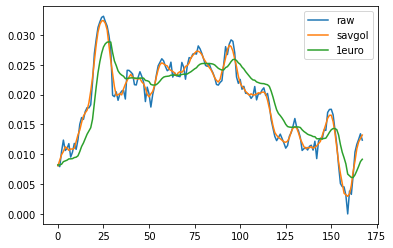

In [37]:
dataSegment = data[t_segment[0]:t_segment[1]]
ref_frame = data[t_ref]
dataSegment = rotateToNeutral(dataSegment[0], dataSegment, staticLandmarkIndices)
leftBrowDistanceFromNeutral = np.square(dataSegment[:,leftBrowIndices]-dataSegment[t_ref:t_ref+1,leftBrowIndices])[:,:,0:2].sum(axis=2)
leftBrowDistanceFromNeutral = np.sqrt(leftBrowDistanceFromNeutral.mean(axis=1))
smoothed_signal = signal.savgol_filter(leftBrowDistanceFromNeutral, min(5, np.floor(leftBrowDistanceFromNeutral.shape[0]/2)*2-1), 1)
plt.plot(leftBrowDistanceFromNeutral[:], label="raw")
plt.plot(smoothed_signal, label="savgol")
t = np.arange(0, dataSegment.shape[0])
x_hat = np.zeros_like(leftBrowDistanceFromNeutral)
x_hat[0] = leftBrowDistanceFromNeutral[0]
one_euro_filter = OneEuroFilter(t[0], leftBrowDistanceFromNeutral[0],min_cutoff=min_cutoff,beta=beta)
for i in range(1, len(t)):
    x_hat[i] = one_euro_filter(t[i], leftBrowDistanceFromNeutral[i])
plt.plot(x_hat, label="1euro")
# x_hat = constrainedOneEuroFilter(leftBrowDistanceFromNeutral, t_segment, [t_ref])
# plt.plot(x_hat, label="2euro")
plt.legend()


# 2.2 General contour information, shape contour, segment of interest

In [19]:
def relative_feature_vector(input_contour):
    input_contour_tiled = np.tile(input_contour, [1, input_contour.shape[0]])
    input_contour_T_tiled = np.tile(input_contour.reshape(input_contour.shape[0]*input_contour.shape[1],1).T, [input_contour.shape[0], 1])
    relative_dif = input_contour_tiled - input_contour_T_tiled
    relative_dif = relative_dif.reshape((input_contour.shape[0]*input_contour.shape[0],3))
    relative_dif = np.linalg.norm(relative_dif, axis=1)
    return relative_dif
def contour_t_comparison(input_contour_set, reference_frame):
    f0 = relative_feature_vector(reference_frame)
    out = np.zeros((input_contour_set.shape[0], ))
    for i in range(0, input_contour_set.shape[0]):
        fi = relative_feature_vector(input_contour_set[i])
        np.square(f0-fi).sum()
        out[i] = np.square(f0-fi).sum()
    return out
def outputToFile(path, arr, fps, start):
    # the input should be in the form of a 2D array with shape [n, ]
    arr_length = arr.shape[0]
    dt = 1.0 / fps
    t_arr = np.arange(0, arr_length) * dt + start
    t_arr = t_arr.tolist()
    arr = arr / arr.max()
    v_arr = arr.tolist()
    
    output = {"t": t_arr, "v": v_arr}
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(output, f)
    return
print(smoothed_signal.shape)
outputToFile(outputPath, x_hat, fps, start)




(168,)


# 2.3 General contour information, turning angle distance, segment of interest

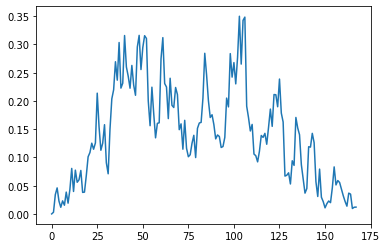

In [20]:
def turning_feature_vector(input_contour):
    # input contour should be shaped (n, 2), with m being the number of 2D dimensions X and Y
    v1 = np.zeros((input_contour.shape[0]+1, input_contour.shape[1]))
    v1[1:] = input_contour
    v1[0] = input_contour[-1]
    v2 = np.zeros((input_contour.shape[0]+1, input_contour.shape[1]))
    v2[0:-1] = input_contour
    v = v2-v1
    theta = np.arctan2(v[:, 0], v[:, 1])[0:-1]
#     print(theta)
    return theta
leftBrowIndices_loop = maping["brow"]["leftUpper"]+list(reversed(maping["brow"]["leftLower"]))
leftBrowData = dataSegment[:,leftBrowIndices_loop]
refFrame = leftBrowData[0]
f_0 = turning_feature_vector(refFrame[:, 0:2])
dist = np.zeros((dataSegment.shape[0], ))
for i in range(0, dataSegment.shape[0]):
    dist[i] = np.square(f_0-turning_feature_vector(leftBrowData[i, :, 0:2])).sum()
plt.plot(dist)

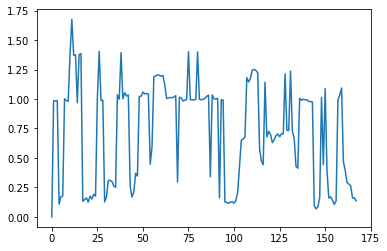

In [21]:
lipIndices_loop = maping["lips"]["outer"]+list(reversed(maping["lips"]["inner"]))
lipData = dataSegment[:,lipIndices_loop]
refFrame = lipData[0]
f_0 = turning_feature_vector(refFrame[:, 0:2])
dist = np.zeros((dataSegment.shape[0], ))
for i in range(0, dataSegment.shape[0]):
    dist[i] = np.sqrt(np.square(f_0-turning_feature_vector(lipData[i, :, 0:2])).mean())
plt.plot(dist)

# 3. Use shear to correct landmarks

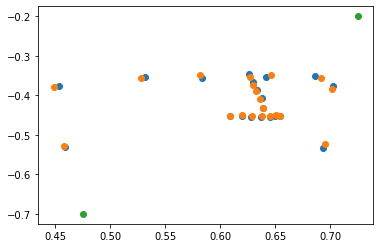

In [46]:
def getSheerMat(dimensions=3):
    out = []
    if dimensions == 3:
        sheer_x_y = np.eye(3)
        sheer_x_y[1,0] = 1
        sheer_x_z = np.eye(3)
        sheer_x_z[2,0] = 1
        
        sheer_y_x = np.eye(3)
        sheer_y_x[0,1] = 1
        sheer_y_z = np.eye(3)
        sheer_y_z[2,1] = 1
        
        sheer_z_x = np.eye(3)
        sheer_z_x[0,2] = 1
        sheer_z_y = np.eye(3)
        sheer_z_y[1,2] = 1
        out = [sheer_x_y, sheer_x_z, sheer_y_x, sheer_y_z, sheer_z_x, sheer_z_y]
    return out
        

def shearBasis(landmarks, anchor, transformations):
    # this function expect pointCloud to be in the shape of [3, n]
    # anchor should be the shape [3, 1]
    # return a set of differential blendshapes that represents the pointCloud, centered
    # around the anchor, sheared in all 6 directions.
    # returns a list of arrays, with shape of [3, n], these are differential blendshapes
    
    out = []
    centered_landmarks = landmarks - anchor
    for trans in transformations:
        out.append((trans @ centered_landmarks + anchor - landmarks))
    return out, landmarks
def inverseIK(blendshapes, baseshape, target, indices):
    # baseshape and target should both in shape of [3, n]
    # blendshape is a list of arrays with shape [3, n]
    
    diff = (target[:, indices] - baseshape[:, indices]).reshape([target.shape[0]*len(indices), 1])
    B = []
    for i in range(0, len(blendshapes)):
        mat = blendshapes[i][:, indices].reshape([target.shape[0]*len(indices), ])
        B.append(np.expand_dims(mat, axis=0))
    B = np.concatenate(B, axis=0)
    w = np.linalg.inv(B@B.T)@B@diff
    return w
t = 70
def shearNormalization(data, neutral_frame, shear_landmarkSet, rotation=True, rotation_landmarkset=None):
    data_0 = neutral_frame
    out_data = []
    basis_transformation = getSheerMat()
    for t in range(0, len(data)):
        data_1 = data[t]
        shearCenter = [4]
        if rotation:
            R, c, t = compute_rotation(data_1[rotation_landmarkset].T, data_0[rotation_landmarkset].T)
            norm_data_1 = (c*R @ data_1.T+t).T
        else:
            norm_data_1 = data_1
        # do the shear transformtions
        basis, neutral = shearBasis(norm_data_1.T, norm_data_1[shearCenter].T, basis_transformation)
        # basis and neutralis that of the entire mesh
        w = inverseIK(basis, neutral, data_0.T, shear_landmarkSet)
        sheared_data_1 = neutral
        for i in range(0, len(basis)):
            sheared_data_1 = sheared_data_1 + w[i] * basis[i]
        sheared_data_1 = sheared_data_1.T
        out_data.append(np.expand_dims(sheared_data_1, axis=0))
    out_data = np.concatenate(out_data, axis=0)
    return out_data
def iterativeNormalization(data, neutral_frame, rotation_landmarkset, sheer_landmarkset):
    out_data = shearNormalization(data, neutral_frame, sheer_landmarkset, rotation=True, rotation_landmarkset=rotation_landmarkset)
    out_data = shearNormalization(out_data, neutral_frame, sheer_landmarkset, rotation=True, rotation_landmarkset=rotation_landmarkset)
    out_data = shearNormalization(out_data, neutral_frame, sheer_landmarkset, rotation=True, rotation_landmarkset=rotation_landmarkset)
    return out_data

i = 90
iterativenormData = iterativeNormalization(dataSegment, ref_frame, staticLandmarkIndices, staticLandmarkIndices)
shearedData = shearNormalization(data, data[0], staticLandmarkIndices, rotation_landmarkset=staticLandmarkIndices)
sheared_data_1  = shearedData[i]
# plt.scatter(sheared_data_1[staticLandmarkIndices, 0], -sheared_data_1[staticLandmarkIndices, 1])
plt.scatter(iterativenormData[i][staticLandmarkIndices, 0], -iterativenormData[i][staticLandmarkIndices, 1])
plt.scatter(data[0][staticLandmarkIndices, 0], -data[0][staticLandmarkIndices, 1])
plt.scatter([0.475, 0.725], [-0.7, -0.2])

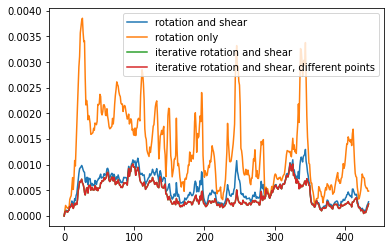

In [53]:
iterative_normalized_data = iterativeNormalization(data, data[0], staticLandmarkIndices, staticLandmarkIndices)
shear_rotated_data = shearNormalization(data, data[0], staticLandmarkIndices, rotation=True, rotation_landmarkset=staticLandmarkIndices)
rotated_data = rotateToNeutral(data[0], data, staticLandmarkIndices)
fitting_error = shear_rotated_data[:, staticLandmarkIndices] - data[0, staticLandmarkIndices]
fitting_error = np.square(fitting_error).sum(axis=2).sum(axis=1)
plt.plot(fitting_error, label="rotation and shear")
fitting_error = rotated_data[:, staticLandmarkIndices] - data[0, staticLandmarkIndices]
fitting_error = np.square(fitting_error).sum(axis=2).sum(axis=1)
plt.plot(fitting_error, label="rotation only")
fitting_error = iterative_normalized_data[:, staticLandmarkIndices] - data[0, staticLandmarkIndices]
fitting_error = np.square(fitting_error).sum(axis=2).sum(axis=1)
plt.plot(fitting_error, label="iterative rotation and shear")
plt.legend()

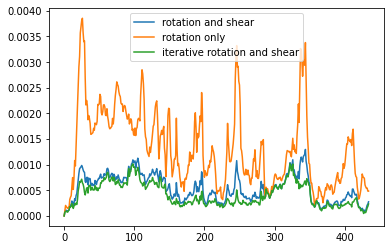

In [41]:
staticLandmarkIndices = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]

iterative_normalized_data = iterativeNormalization(data, data[0], staticLandmarkIndices, staticLandmarkIndices)
shear_rotated_data = shearNormalization(data, data[0], staticLandmarkIndices, rotation=True, rotation_landmarkset=staticLandmarkIndices)
rotated_data = rotateToNeutral(data[0], data, staticLandmarkIndices)
fitting_error = shear_rotated_data[:, staticLandmarkIndices] - data[0, staticLandmarkIndices]
fitting_error = np.square(fitting_error).sum(axis=2).sum(axis=1)
plt.plot(fitting_error, label="rotation and shear")
fitting_error = rotated_data[:, staticLandmarkIndices] - data[0, staticLandmarkIndices]
fitting_error = np.square(fitting_error).sum(axis=2).sum(axis=1)
plt.plot(fitting_error, label="rotation only")
fitting_error = iterative_normalized_data[:, staticLandmarkIndices] - data[0, staticLandmarkIndices]
fitting_error = np.square(fitting_error).sum(axis=2).sum(axis=1)
plt.plot(fitting_error, label="iterative rotation and shear")
plt.legend()

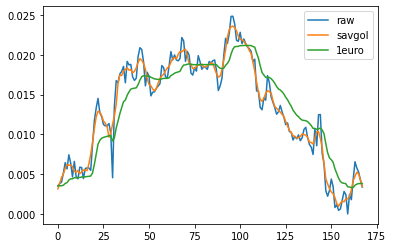

In [47]:
dataSegment = data[t_segment[0]:t_segment[1]]
ref_frame = data[0]
dataSegment = iterativeNormalization(dataSegment, ref_frame, staticLandmarkIndices, staticLandmarkIndices)
leftBrowDistanceFromNeutral = np.square(dataSegment[:,leftBrowIndices]-dataSegment[t_ref:t_ref+1,leftBrowIndices])[:,:,0:2].sum(axis=2)
leftBrowDistanceFromNeutral = np.sqrt(leftBrowDistanceFromNeutral.mean(axis=1))
smoothed_signal = signal.savgol_filter(leftBrowDistanceFromNeutral, min(5, np.floor(leftBrowDistanceFromNeutral.shape[0]/2)*2-1), 1)
plt.plot(leftBrowDistanceFromNeutral[:], label="raw")
plt.plot(smoothed_signal, label="savgol")
t = np.arange(0, dataSegment.shape[0])
x_hat = np.zeros_like(leftBrowDistanceFromNeutral)
x_hat[0] = leftBrowDistanceFromNeutral[0]
one_euro_filter = OneEuroFilter(t[0], leftBrowDistanceFromNeutral[0],min_cutoff=min_cutoff,beta=beta)
for i in range(1, len(t)):
    x_hat[i] = one_euro_filter(t[i], leftBrowDistanceFromNeutral[i])
plt.plot(x_hat, label="1euro")
# x_hat = constrainedOneEuroFilter(leftBrowDistanceFromNeutral, t_segment, [t_ref])
# plt.plot(x_hat, label="2euro")
plt.legend()
outputToFile(outputPath, x_hat, fps, start)


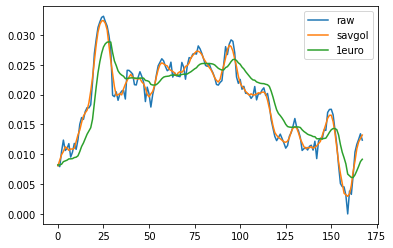

In [43]:
dataSegment = data[t_segment[0]:t_segment[1]]
ref_frame = data[0]
dataSegment = rotateToNeutral(dataSegment[0], dataSegment, staticLandmarkIndices)
leftBrowDistanceFromNeutral = np.square(dataSegment[:,leftBrowIndices]-dataSegment[t_ref:t_ref+1,leftBrowIndices])[:,:,0:2].sum(axis=2)
leftBrowDistanceFromNeutral = np.sqrt(leftBrowDistanceFromNeutral.mean(axis=1))
smoothed_signal = signal.savgol_filter(leftBrowDistanceFromNeutral, min(5, np.floor(leftBrowDistanceFromNeutral.shape[0]/2)*2-1), 1)
plt.plot(leftBrowDistanceFromNeutral[:], label="raw")
plt.plot(smoothed_signal, label="savgol")
t = np.arange(0, dataSegment.shape[0])
x_hat = np.zeros_like(leftBrowDistanceFromNeutral)
x_hat[0] = leftBrowDistanceFromNeutral[0]
one_euro_filter = OneEuroFilter(t[0], leftBrowDistanceFromNeutral[0],min_cutoff=min_cutoff,beta=beta)
for i in range(1, len(t)):
    x_hat[i] = one_euro_filter(t[i], leftBrowDistanceFromNeutral[i])
plt.plot(x_hat, label="1euro")
# x_hat = constrainedOneEuroFilter(leftBrowDistanceFromNeutral, t_segment, [t_ref])
# plt.plot(x_hat, label="2euro")
plt.legend()
